# Mangrove classification - v6
#### Determining training samples

    ✅ Load Landsat data for 2016
    ✅ Calculate vegetation indices
    ✅ Establish mangrove threshold based on exploratory analysis
    ✅ Remove inland water bodies
    ✅ Perform k-means classification
    ✅ Select classes based on ground validation data

#### Classification (1987 - 2023)

    ✅ Train the model (include classification report and confusion matrix)
            ✅ Include optimal parameters analysis
    ✅ Perform the classification
            ✅ Improve thresholding (maybe use the same from k-means)
    ✅ Remove salt and pepper noise through majority filter

#### Exporting data

    ✅ Export NDVI, NDWI, FVC, FPC, distance to water, and class of each pixel

Rogerio VS Goncalves - 06/03/2025

###### *ChatGPT 4o was responsibly used in this code for optimising and debugging


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import rioxarray as rio
import seaborn as sns
import shapely.geometry
import sys
import xarray as xr
import datacube

from datacube import Datacube
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from datetime import datetime
from dea_tools.bandindices import calculate_indices
from dea_tools.coastal import get_coastlines
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from matplotlib import colors
from rasterio.features import geometry_mask, rasterize
from scipy.ndimage import generic_filter
from scipy.ndimage import distance_transform_edt as distance_transform
from scipy.ndimage import binary_opening
from scipy.stats import mode
import seaborn as sns
from skimage.measure import label
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, calinski_harabasz_score, classification_report, cohen_kappa_score, confusion_matrix, silhouette_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

dc = datacube.Datacube()






In [3]:
### Defining functions

# Define a function to apply a majority filter (remove salt and pepper noise)
def mode_filter_func(values):
    mode_value = np.bincount(values.astype(int)).argmax()
    return mode_value

# Function to filter small clusters of pixels
def filter_small_clusters(pixel_values, min_size=2):
    # Label connected components in the array
    labeled_array = label(pixel_values > -1)  # Assumes pixel values > -1 are valid
    component_sizes = np.bincount(labeled_array.ravel())  # Count size of each component
    
    # Create a mask for large components (greater than min_size)
    large_component_mask = np.zeros_like(pixel_values, dtype=bool)
    for component, size in enumerate(component_sizes):
        if size >= min_size:
            large_component_mask[labeled_array == component] = True
    
    # Apply the mask: retain large components and set smaller ones to -1
    filtered_array = np.where(large_component_mask, pixel_values, -1)
    
    return filtered_array
    

# Preparing data for K-means classification

### Loading data

##### Landsat

In [4]:
query_ls = {
    'x': (139.60445, 139.94966),
    'y': (-17.51889, -17.76353),
    'time': ('2015', '2017'),
    'output_crs': 'EPSG:3577',
    'resolution': (-25, 25),
    'group_by': 'solar_day'
}

ds = load_ard(dc=dc, products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], min_gooddata=0.99, **query_ls)

# Resample Landsat data to get 2016
ls_resampled = ds.resample(time='1Y').median()
ls_2016 = ls_resampled.sel(time='2016')


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 24 out of 190 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 24 time steps


/env/lib/python3.10/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [5]:
ls_2016

<xarray.Dataset> Size: 158MB
Dimensions:                     (time: 1, y: 1170, x: 1530)
Coordinates:
  * y                           (y) float64 9kB -1.893e+06 ... -1.922e+06
  * x                           (x) float64 12kB 8.064e+05 ... 8.447e+05
    spatial_ref                 int32 4B 3577
  * time                        (time) datetime64[ns] 8B 2016-12-31
Data variables: (12/20)
    nbart_blue                  (time, y, x) float32 7MB 1.061e+03 ... 1.017e+03
    nbart_green                 (time, y, x) float32 7MB 1.596e+03 ... 1.696e+03
    nbart_red                   (time, y, x) float32 7MB 1.977e+03 ... 2.236e+03
    nbart_nir                   (time, y, x) float32 7MB 2.674e+03 ... 3.016e+03
    nbart_swir_1                (time, y, x) float32 7MB 3.552e+03 ... 3.916e+03
    nbart_swir_2                (time, y, x) float32 7MB 2.8e+03 ... 3.36e+03
    ...                          ...
    oa_satellite_view           (time, y, x) float32 7MB 5.211 5.209 ... 1.572
    oa_solar_azimuth            (time, y, x) float32 7MB 49.1 49.1 ... 48.51
    oa_solar_zenith             (time, y, x) float32 7MB 41.01 41.01 ... 40.9
    oa_time_delta               (time, y, x) float32 7MB 4.358 4.358 ... 7.347
    oa_fmask                    (time, y, x) float64 14MB 1.0 1.0 ... 1.0 1.0
    oa_nbart_contiguity         (time, y, x) float64 14MB 1.0 1.0 ... 1.0 1.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Calculating indices

In [6]:
## 2015
ls_2015 = ls_resampled.sel(time='2015')
ls_2015_NDVI = calculate_indices(ls_2015, index='NDVI', collection='ga_ls_3')
ls_2015['NDVI'] = ls_2015_NDVI['NDVI']

ls_2015_MNDWI = calculate_indices(ls_2015, index='MNDWI', collection='ga_ls_3')
ls_2015['MNDWI'] = ls_2015_MNDWI['MNDWI']


## 2016
# NDVI
ls_2016_NDVI = calculate_indices(ls_2016, index='NDVI', collection='ga_ls_3')
ls_2016['NDVI'] = ls_2016_NDVI['NDVI']

# Add NDVI_2015 to ls_2016 ensuring coordinates and time match
ls_2016 = ls_2016.assign(NDVI_2015=ls_2016['NDVI'].squeeze().drop_vars('time'))

# delta NDVI
ls_2016['deltaNDVI'] = ls_2016_NDVI['NDVI'].squeeze() - ls_2015_NDVI['NDVI'].squeeze()

# NDWI
ls_2016_NDWI = calculate_indices(ls_2016, index='NDWI', collection='ga_ls_3')
ls_2016['NDWI'] = ls_2016_NDWI['NDWI']
ls_2016

ls_2016_MNDWI = calculate_indices(ls_2016, index='MNDWI', collection='ga_ls_3')
ls_2016['MNDWI'] = ls_2016_MNDWI['MNDWI']

# WI
ls_2016_WI = calculate_indices(ls_2016, index='WI', collection='ga_ls_3')
ls_2016['WI'] = ls_2016_WI['WI']

# MMRI
# Calculate absolute values
abs_NDVI = np.abs(ls_2016_NDVI['NDVI'].squeeze())
abs_MNDWI = np.abs(ls_2016_MNDWI['MNDWI'].squeeze())

# Calculate MMRI
ls_2016['MMRI'] = (abs_MNDWI - abs_NDVI) / (abs_MNDWI + abs_NDVI)
ls_2016


# Calculate absolute values
abs_NDVI_2015 = np.abs(ls_2015_NDVI['NDVI'].squeeze())
abs_MNDWI_2015 = np.abs(ls_2015_MNDWI['MNDWI'].squeeze())

# Calculate MMRI
ls_2015['MMRI_2015'] = (abs_MNDWI_2015 - abs_NDVI_2015) / (abs_MNDWI_2015 + abs_NDVI_2015)
ls_2016['MMRI_2015'] = ls_2015['MMRI_2015']
ls_2016['deltaMMRI'] = ls_2016['MMRI'].squeeze() - ls_2015['MMRI_2015'].squeeze()
ls_2016


<xarray.Dataset> Size: 222MB
Dimensions:                     (time: 1, y: 1170, x: 1530)
Coordinates:
  * y                           (y) float64 9kB -1.893e+06 ... -1.922e+06
  * x                           (x) float64 12kB 8.064e+05 ... 8.447e+05
    spatial_ref                 int32 4B 3577
  * time                        (time) datetime64[ns] 8B 2016-12-31
Data variables: (12/29)
    nbart_blue                  (time, y, x) float32 7MB 1.061e+03 ... 1.017e+03
    nbart_green                 (time, y, x) float32 7MB 1.596e+03 ... 1.696e+03
    nbart_red                   (time, y, x) float32 7MB 1.977e+03 ... 2.236e+03
    nbart_nir                   (time, y, x) float32 7MB 2.674e+03 ... 3.016e+03
    nbart_swir_1                (time, y, x) float32 7MB 3.552e+03 ... 3.916e+03
    nbart_swir_2                (time, y, x) float32 7MB 2.8e+03 ... 3.36e+03
    ...                          ...
    NDWI                        (time, y, x) float32 7MB -0.2526 ... -0.2803
    MNDWI                       (time, y, x) float32 7MB -0.3801 ... -0.3958
    WI                          (time, y, x) float32 7MB -24.99 ... -31.21
    MMRI                        (y, x) float32 7MB 0.4345 0.4492 ... 0.4543
    MMRI_2015                   (y, x) float32 7MB 0.4393 0.4577 ... 0.4537
    deltaMMRI                   (y, x) float32 7MB -0.004806 ... 0.0005745
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

##### Plotting histograms

#### Calculating distance to ocean

/tmp/ipykernel_155/1941716348.py:10: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  merged_coastline = coastline_2016.explode().geometry.unary_union


Coordinate Reference System (CRS): EPSG:3577
Resolution (pixel width and height): (25.0, -25.0)


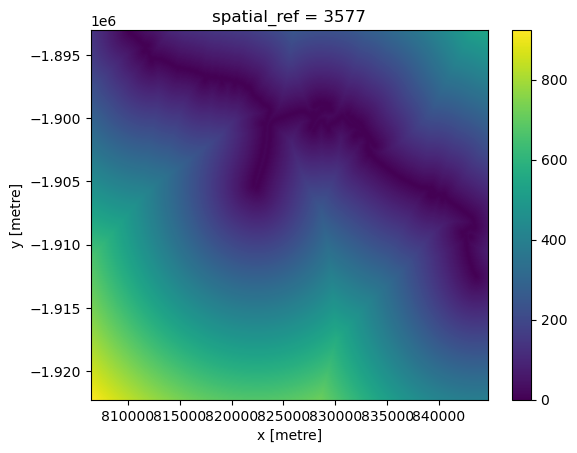

In [7]:
# Specify bounding box
ymax, xmin = -17.51889, 139.60445
ymin, xmax = -17.76353, 139.94966

# Load and filter DEA Coastlines annual shorelines data for 2016
coastline_2016 = get_coastlines(bbox=(xmin, ymin, xmax, ymax), layer='shorelines_annual')
coastline_2016 = coastline_2016[coastline_2016['year'] == 2016]

# Merge lines into a single LineString
merged_coastline = coastline_2016.explode().geometry.unary_union

# Prepare and rasterize the GeoDataFrame with the merged coastline
mask_rasterized = rasterize(
    shapes=[merged_coastline],
    out_shape=ls_2016['deltaNDVI'].shape,
    transform=ls_2016.rio.transform(),
    fill=0,
    all_touched=True,
    dtype='uint8'
)

# Calculate the Euclidean distance to the coastline
distances = distance_transform(mask_rasterized == 0)

# Create a new DataArray with the distances
distances_da = xr.DataArray(
    data=distances,
    dims=ls_2016['deltaNDVI'].dims,
    coords=ls_2016['deltaNDVI'].coords,
    attrs=ls_2016['deltaNDVI'].attrs
)
distances_da.rio.write_nodata(-999, inplace=True)

# Save the distance as a GeoTIFF
write_cog(geo_im=distances_da, fname='distance_to_coastline.tif', overwrite=True)

# Print CRS and resolution for doublechecking
print("Coordinate Reference System (CRS):", ls_2016.rio.crs)
print("Resolution (pixel width and height):", ls_2016.rio.resolution())

# Save to dataset
ls_2016['distance_to_coastline'] = distances_da

# Plot the distances
distances_da.plot()


#### Removing non-mangrove pixels
###### Create a mangrove mask

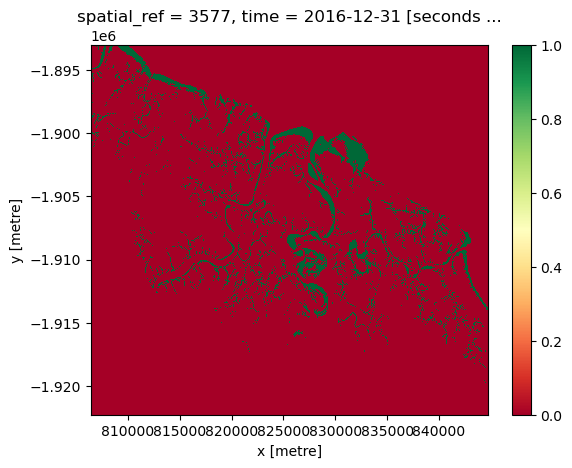

In [8]:
# Threshold definition based on the data exploration
mmri_threshold = 0
mndwi_threshold = -0.5
ndwi_threshold = -0.25
deltaMMRI_threshold = 0.15
distance_threshold = 480 # this is equivalent to 12 km

# Define exclusion masks
mmri_mask = ls_2016['MMRI'] < mmri_threshold
mndwi_mask_2016 = ls_2016['MNDWI'] > mndwi_threshold
ndwi_mask_2016 = ls_2016['NDWI'] < ndwi_threshold
distance_mask = ls_2016['distance_to_coastline'] < distance_threshold

# Combine exclusion masks using logical AND
exclusion_mask = mmri_mask & mndwi_mask_2016

# Define the inclusion mask
dmmri_mask_2016 = ls_2016['deltaMMRI'] > deltaMMRI_threshold

# Combine the exclusion and inclusion masks
combined_mask = (exclusion_mask | dmmri_mask_2016) & ndwi_mask_2016 & distance_mask

# Ensure combined_mask is a binary mask and convert to integer
combined_mask = combined_mask.astype(np.uint8)

# Plot the binary mask for verification
combined_mask.isel(time=0).plot(cmap='RdYlGn')

# Apply majority filter to the mask using generic_filter
filtered_mask = generic_filter(combined_mask, mode_filter_func, size=3)

# Ensure the filtered mask is binary
filtered_mask = (filtered_mask > 0).astype(np.uint8)

# Convert the numpy array back to an xarray DataArray and assign attributes
filtered_mask_da = xr.DataArray(
    filtered_mask,
    dims=combined_mask.dims,
    coords=combined_mask.coords,
    attrs=ls_2016.attrs
)

# Write the filtered mask to a GeoTIFF file
write_cog(
    geo_im=filtered_mask_da,
    fname='filtered_combined_mask_230924_v5a.tif',
    overwrite=True
)

# Reindexing the mask to align it with the dataset coordinates
aligned_mask = filtered_mask_da.reindex_like(ls_2016, method='nearest')

# Apply the aligned mask to the dataset
ls_2016_masked = ls_2016.where(aligned_mask, drop=False)


# Performing K-means classification

/tmp/ipykernel_155/3392233187.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  rows, cols = ls_2016_masked.dims['y'], ls_2016_masked.dims['x']  # Get the original dimensions


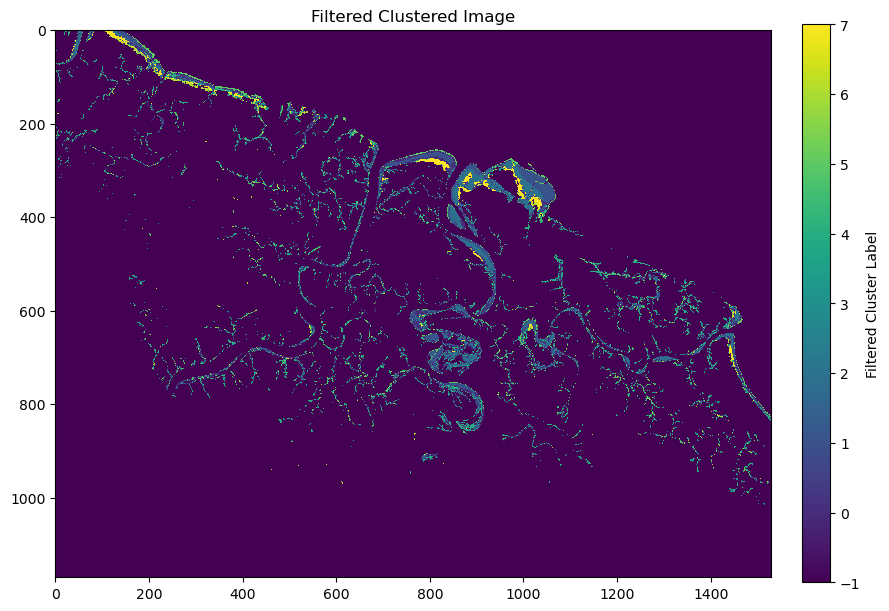

Processed and saved filtered clusters raster to ./20241014_filtered_clusters_2016.tif


In [9]:
# Define bands to use
bands = ['deltaNDVI', 'nbart_blue', 'nbart_green', 'nbart_nir', 'nbart_red', 'nbart_swir_1', 'nbart_swir_2', 'NDVI_2015', 'NDVI']

# Flatten each band data and create a mask for valid pixels
pixels = np.column_stack([ls_2016_masked[band].values.flatten() for band in bands])
valid_pixels_mask = ~np.isnan(pixels).any(axis=1)  # Removing NaN

# Standardize the features for valid pixels only
scaler = StandardScaler()
valid_pixels_scaled = scaler.fit_transform(pixels[valid_pixels_mask])

# Apply K-Means clustering to the valid pixels
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(valid_pixels_scaled)
valid_labels = kmeans.labels_

# Create an array to hold all labels, starting with a value to indicate invalid/missing data
all_labels = np.full(pixels.shape[0], fill_value=-1)

# Place the valid labels in their original positions
all_labels[valid_pixels_mask] = valid_labels

# Reshape the labels to the original image's 2D shape
rows, cols = ls_2016_masked.dims['y'], ls_2016_masked.dims['x']  # Get the original dimensions
clustered_image = all_labels.reshape(rows, cols)

# Apply filtering to remove small clusters
filtered_clusters = filter_small_clusters(clustered_image, min_size=2)

# Visualization of filtered clusters
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(filtered_clusters, cmap='viridis', interpolation='none')
plt.title('Filtered Clustered Image')
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Filtered Cluster Label')
plt.show()

# Convert the filtered_clusters ndarray into an xarray DataArray
filtered_da = xr.DataArray(
    data=filtered_clusters.astype(np.int16),
    dims=['y', 'x'],
    coords={'y': ls_2016_masked.coords['y'], 'x': ls_2016_masked.coords['x']},
    name='filtered_clusters'
)

# Remove time dimension for applying the mask
if 'time' in filtered_da.dims and filtered_da['time'].size == 1:
    filtered_da = filtered_da.squeeze('time')  

# Reorder dimensions for applying the mask
if filtered_da.dims != ('y', 'x'):
    filtered_da = filtered_da.transpose('y', 'x')  

# Assign CRS and save the filtered clusters and binary map as GeoTIFFs
filtered_da.rio.write_crs('EPSG:3577', inplace=True)

# Save the filtered result to a GeoTIFF
filtered_output_path = "./20241014_filtered_clusters_2016.tif"
filtered_da.rio.to_raster(filtered_output_path, dtype=np.int16, compress='LZW')
print(f"Processed and saved filtered clusters raster to {filtered_output_path}")


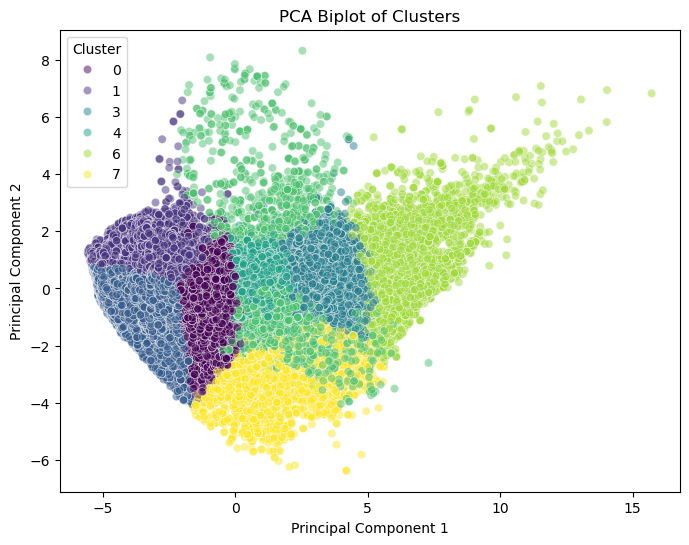


Feature Contributions - Cluster 0
                   PC1       PC2
deltaNDVI     0.468506  0.222417
nbart_blue    0.211493 -0.348102
nbart_green   0.483253 -0.410311
nbart_nir     0.644804  0.403800
nbart_red     0.246290 -0.293087
nbart_swir_1 -0.053070  0.112586
nbart_swir_2 -0.151590  0.110732
NDVI_2015     0.002585  0.439948
NDVI          0.002585  0.439948


<Figure size 1000x600 with 0 Axes>

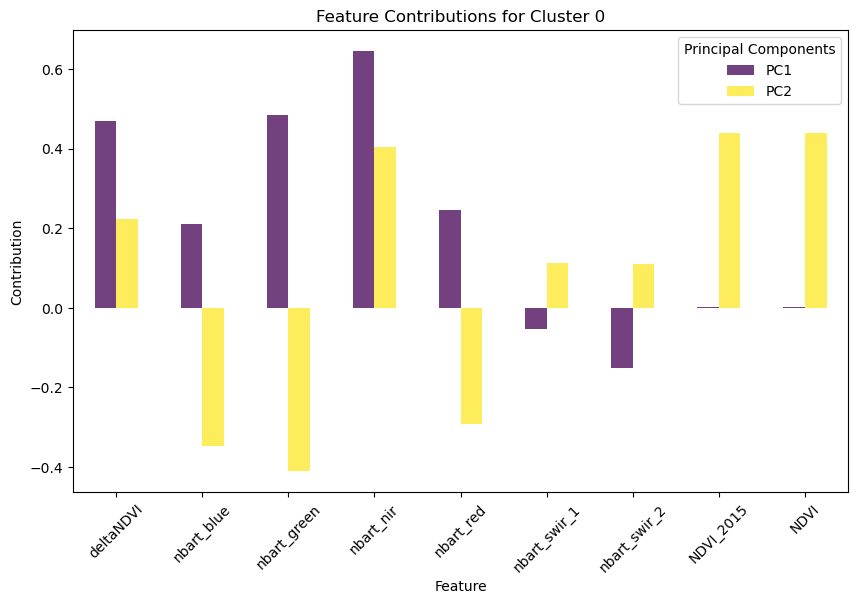


Feature Contributions - Cluster 1
                   PC1       PC2
deltaNDVI    -0.118721  0.346731
nbart_blue   -0.316462  0.181943
nbart_green  -0.378900  0.518262
nbart_nir     0.527438  0.727763
nbart_red    -0.320744  0.194256
nbart_swir_1 -0.240086  0.068168
nbart_swir_2 -0.171195 -0.066232
NDVI_2015     0.370253 -0.028904
NDVI          0.370253 -0.028904


<Figure size 1000x600 with 0 Axes>

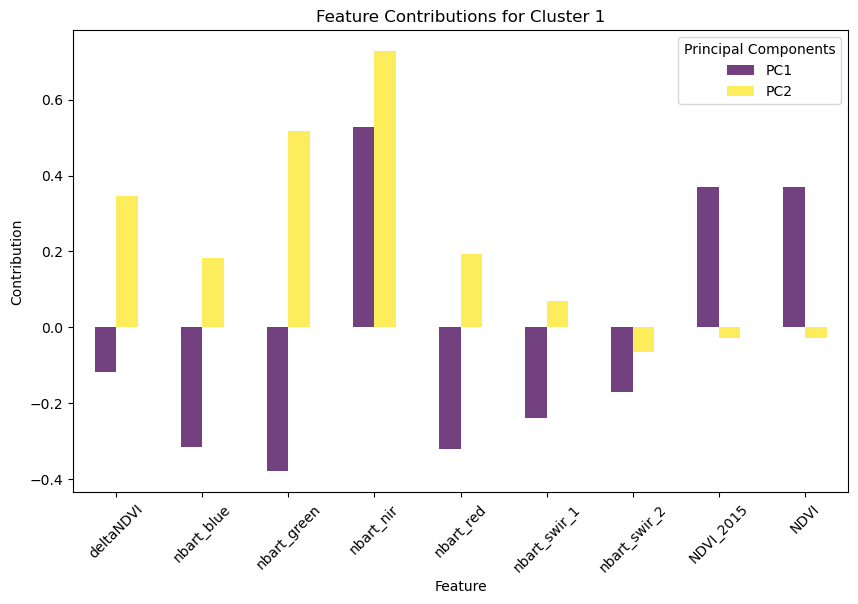


Feature Contributions - Cluster 2
                   PC1       PC2
deltaNDVI     0.101512  0.528221
nbart_blue   -0.246621  0.221257
nbart_green  -0.205828  0.427286
nbart_nir     0.635920  0.551583
nbart_red    -0.220398  0.244891
nbart_swir_1 -0.279814  0.259998
nbart_swir_2 -0.258870  0.169561
NDVI_2015     0.379624 -0.120186
NDVI          0.379624 -0.120186


<Figure size 1000x600 with 0 Axes>

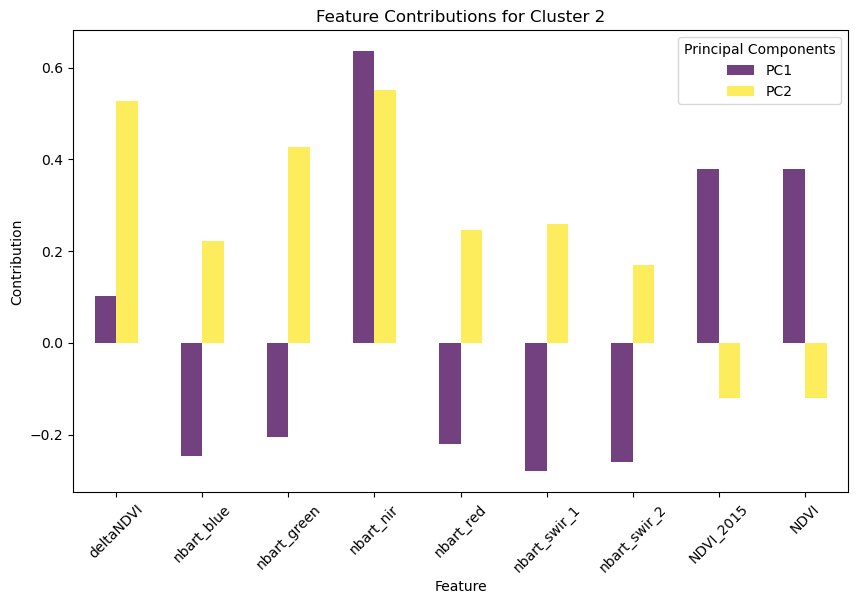


Feature Contributions - Cluster 3
                   PC1       PC2
deltaNDVI     0.395777 -0.093031
nbart_blue   -0.264968  0.366009
nbart_green  -0.239248  0.354762
nbart_nir     0.467388  0.396958
nbart_red    -0.261692  0.365844
nbart_swir_1  0.164609  0.425644
nbart_swir_2  0.230197  0.499867
NDVI_2015     0.417667 -0.067341
NDVI          0.417667 -0.067341


<Figure size 1000x600 with 0 Axes>

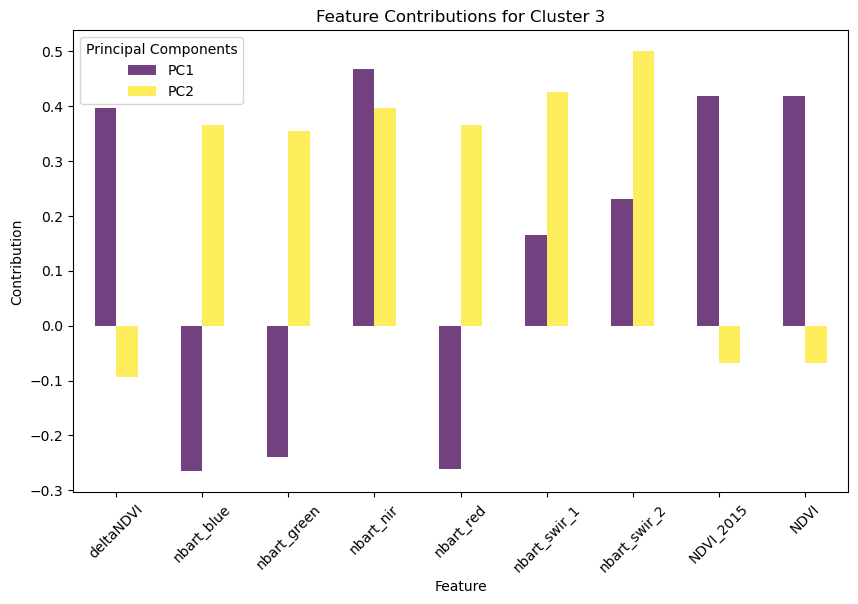


Feature Contributions - Cluster 4
                   PC1       PC2
deltaNDVI     0.265066  0.371184
nbart_blue    0.326020 -0.239107
nbart_green   0.369894 -0.174333
nbart_nir     0.468957  0.563178
nbart_red     0.341773 -0.220536
nbart_swir_1  0.405448 -0.077423
nbart_swir_2  0.410910 -0.077811
NDVI_2015    -0.091283  0.445424
NDVI         -0.091283  0.445424


<Figure size 1000x600 with 0 Axes>

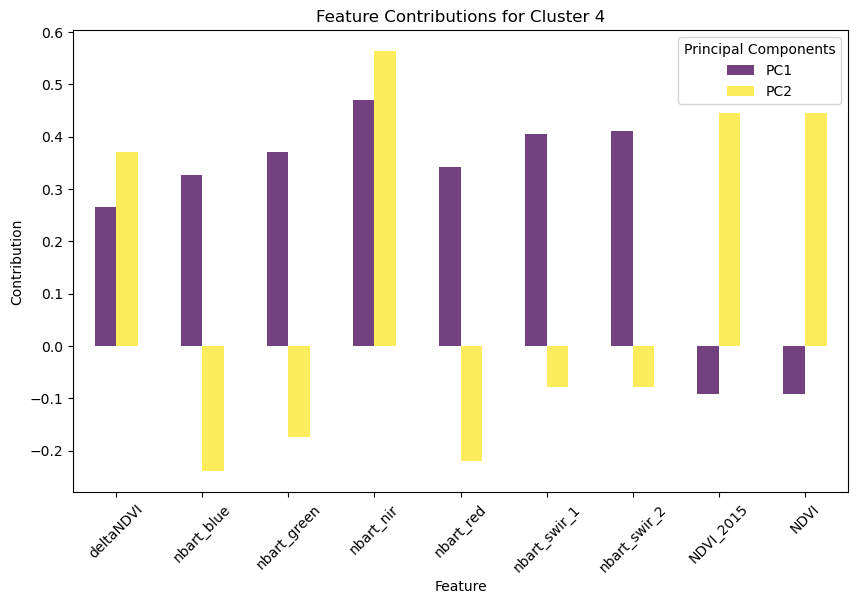


Feature Contributions - Cluster 5
                   PC1       PC2
deltaNDVI     0.985696 -0.009315
nbart_blue    0.040707 -0.260751
nbart_green   0.049698 -0.247341
nbart_nir     0.116480  0.477155
nbart_red     0.097675 -0.214256
nbart_swir_1  0.027202  0.105330
nbart_swir_2 -0.019788  0.037095
NDVI_2015    -0.004341  0.540690
NDVI         -0.004341  0.540690


<Figure size 1000x600 with 0 Axes>

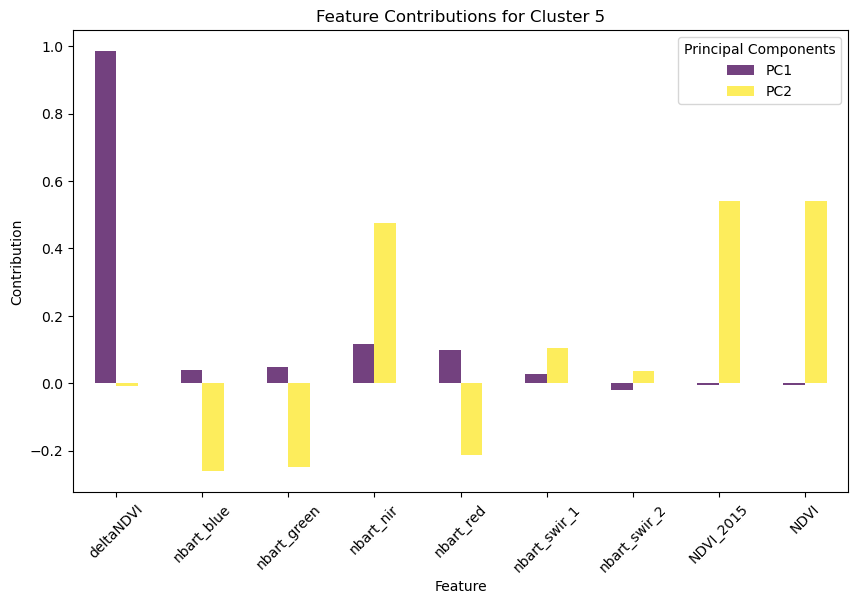


Feature Contributions - Cluster 6
                   PC1       PC2
deltaNDVI     0.223442  0.550761
nbart_blue    0.492123 -0.047694
nbart_green   0.541592 -0.003070
nbart_nir     0.398180  0.353947
nbart_red     0.446988 -0.167081
nbart_swir_1  0.139721 -0.458953
nbart_swir_2  0.185752 -0.447648
NDVI_2015    -0.033130  0.255105
NDVI         -0.033130  0.255105


<Figure size 1000x600 with 0 Axes>

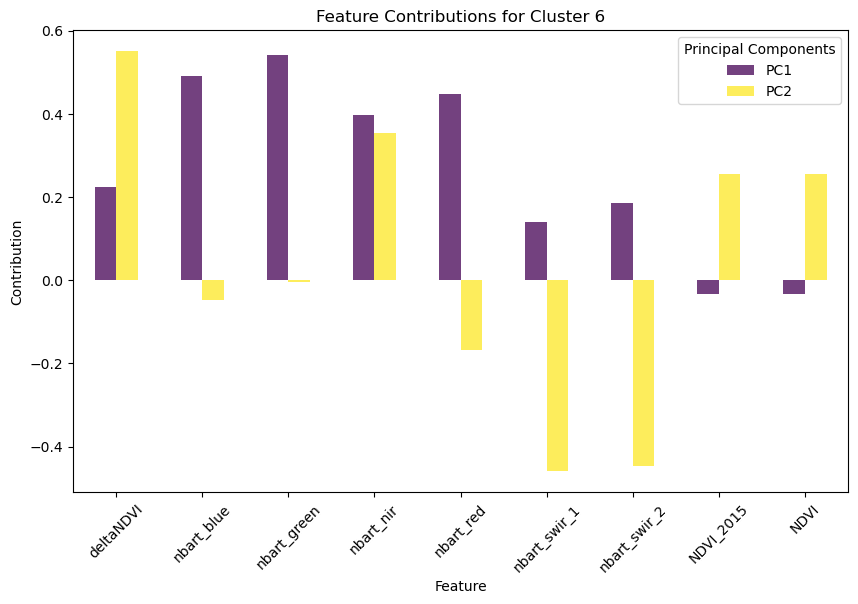


Feature Contributions - Cluster 7
                   PC1       PC2
deltaNDVI    -0.044258  0.775121
nbart_blue    0.413118  0.079816
nbart_green   0.447883  0.267319
nbart_nir     0.181704  0.400614
nbart_red     0.440346  0.108761
nbart_swir_1  0.346439 -0.199987
nbart_swir_2  0.291412 -0.241529
NDVI_2015    -0.312180  0.159226
NDVI         -0.312180  0.159226


<Figure size 1000x600 with 0 Axes>

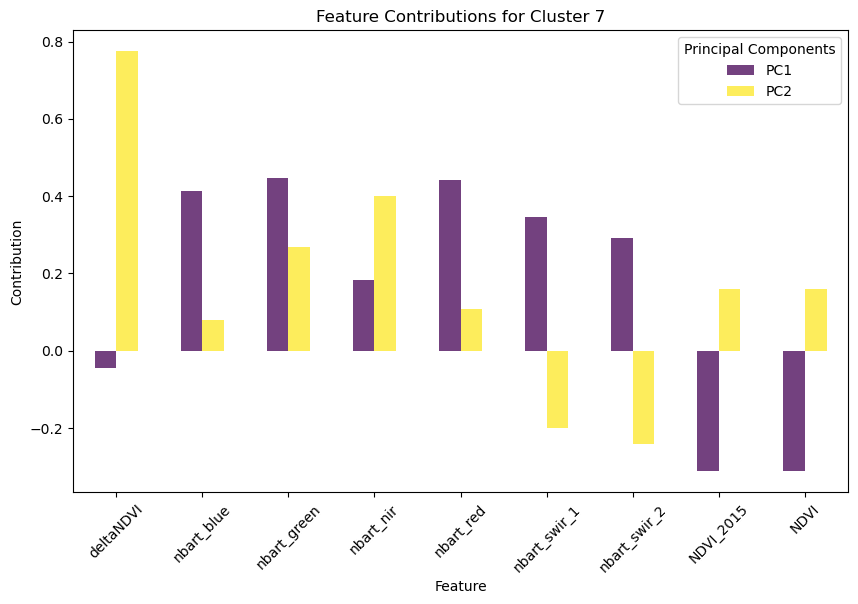

In [10]:
# Compute PCA
pca = PCA(n_components=2)
pca.fit(valid_pixels_scaled)

# Get transformed PCA data
pca_transformed = pca.transform(valid_pixels_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(pca_transformed, columns=["PC1", "PC2"])
df_pca["Cluster"] = valid_labels

# Compute mean PCA values per cluster
pca_cluster_means = df_pca.groupby("Cluster").mean()

# Visualize PCA separation per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=df_pca, palette="viridis", alpha=0.5)
plt.title("PCA Biplot of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Compute feature contributions for each cluster
pca_contributions_per_class = {}
for cluster in np.unique(valid_labels):
    mask = valid_labels == cluster
    if np.sum(mask) > 1:  # Ensure enough samples in the cluster
        pca.fit(valid_pixels_scaled[mask])  # Fit PCA only for this cluster
        pca_contributions_per_class[f"Cluster {cluster}"] = pd.DataFrame(
            pca.components_.T, index=bands, columns=["PC1", "PC2"]
        )

# Print feature contributions per cluster
for cluster_name, df_cluster in pca_contributions_per_class.items():
    print(f"\nFeature Contributions - {cluster_name}")
    print(df_cluster)

    # Plot the contributions of each feature
    plt.figure(figsize=(10, 6))
    df_cluster.plot(kind="bar", figsize=(10, 6), cmap="viridis", alpha=0.75)
    plt.title(f"Feature Contributions for {cluster_name}")
    plt.xlabel("Feature")
    plt.ylabel("Contribution")
    plt.xticks(rotation=45)
    plt.legend(title="Principal Components")
    plt.show()


# Performing random forest classification

In [11]:
# Import k-means clusters
with rasterio.open('20241014_filtered_clusters_2016.tif') as src:
    labels_2016 = src.read(1)

# Flatten the labels
labels_2016_flat = labels_2016.flatten()

ds_2016 = ls_2016

features_2016 = np.column_stack([
                                ds_2016.nbart_blue.values.flatten(), 
                                ds_2016.nbart_green.values.flatten(), 
                                ds_2016.nbart_red.values.flatten(), 
                                ds_2016.nbart_nir.values.flatten(), 
                                ds_2016.nbart_swir_1.values.flatten(), 
                                ds_2016.nbart_swir_2.values.flatten(),
                                ls_2015.NDVI.values.flatten(),
                                ds_2016.deltaNDVI.values.flatten()
                                ])


### Training the model and evaluating

In [9]:
# # Test the best parameters

# # Filter out pixels with invalid data in either features or labels
# valid_mask = (~np.isnan(features_2016).any(axis=1)) & (labels_2016_flat != -1)

# features_valid = features_2016[valid_mask]
# labels_valid = labels_2016_flat[valid_mask]

# # Create a DataFrame for easier manipulation
# data = pd.DataFrame(features_valid)
# data['label'] = labels_valid

# # Initialize lists to store sampled data
# sampled_features = []
# sampled_labels = []

# # Loop through each unique category in the labels
# for category in data['label'].unique():
#     category_data = data[data['label'] == category]
    
#     # Randomly sample 1000 pixels for the current category
#     if len(category_data) > 1000:
#         category_sample = category_data.sample(n=1000, random_state=42)
#     else:
#         category_sample = category_data  # if less than 1000, take all pixels
    
#     sampled_features.append(category_sample.drop(columns='label').values)
#     sampled_labels.append(category_sample['label'].values)

# # Combine the sampled data
# sampled_features = np.vstack(sampled_features)
# sampled_labels = np.concatenate(sampled_labels)

# # Split the sampled data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(sampled_features, sampled_labels, test_size=0.3, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
# }

# # Initialize the classifier
# rf = RandomForestClassifier(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Best parameters and best score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

# # Validate the best model
# best_rf = grid_search.best_estimator_
# y_pred_val = best_rf.predict(X_val)

# print("Classification Report: \n", classification_report(y_val, y_pred_val))
# print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_val))


Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END m

/env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score:  0.9594643469155427
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       291
           1       0.98      0.99      0.99       269
           2       0.98      0.97      0.98       333
           3       0.97      0.95      0.96       286
           4       0.97      0.95      0.96       313
           5       0.98      1.00      0.99       308
           6       0.99      1.00      0.99       300
           7       0.98      1.00      0.99       300

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400

Confusion Matrix: 
 [[277   3   4   0   4   1   0   2]
 [  1 267   1   0   0   0   0   0]
 [  8   2 323   0   0   0   0   0]
 [  0   0   0 271   4   3   4   4]
 [  7   0   0   6 297   2 

In [12]:
# Import necessary functions for AUC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Filter out pixels with invalid data in either features or labels
valid_mask = (~np.isnan(features_2016).any(axis=1)) & (labels_2016_flat != -1)

features_valid = features_2016[valid_mask]
labels_valid = labels_2016_flat[valid_mask]

# Create a DataFrame for easier manipulation
data = pd.DataFrame(features_valid)
data['label'] = labels_valid

# Initialize lists to store sampled data
sampled_features = []
sampled_labels = []

# Loop through each unique category in the labels
for category in data['label'].unique():
    category_data = data[data['label'] == category]
    
    # Randomly sample 250 pixels for the current category
    if len(category_data) > 250:
        category_sample = category_data.sample(n=250, random_state=42)
    else:
        category_sample = category_data  # if less than 1000, take all
    
    sampled_features.append(category_sample.drop(columns='label').values)
    sampled_labels.append(category_sample['label'].values)

# Combine the sampled data
sampled_features = np.vstack(sampled_features)
sampled_labels = np.concatenate(sampled_labels)

# Split the sampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(sampled_features, sampled_labels, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# Validate the model
y_pred_val = clf.predict(X_val)

# # Binarize the labels for AUC calculation
# y_val_bin = label_binarize(y_val, classes=np.unique(y_train))

# # Get the predicted probabilities
# y_pred_proba = clf.predict_proba(X_val)

# # Calculate the AUC for the multiclass problem (one-vs-rest)
# auc = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr')
# print(f"AUC: {auc}")

# Print classification report and confusion matrix
print("Classification Report: \n", classification_report(y_val, y_pred_val))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_val))



Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88        76
           1       0.91      0.91      0.91        69
           2       0.94      0.92      0.93        91
           3       0.96      0.90      0.93        80
           4       0.94      0.88      0.91        66
           5       0.94      0.96      0.95        80
           6       0.95      0.99      0.97        77
           7       0.98      0.97      0.98        61

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Confusion Matrix: 
 [[70  2  2  0  1  1  0  0]
 [ 2 63  3  0  0  1  0  0]
 [ 3  4 84  0  0  0  0  0]
 [ 0  0  0 72  2  2  4  0]
 [ 5  0  0  1 58  1  0  1]
 [ 3  0  0  0  0 77  0  0]
 [ 0  0  0  1  0  0 76  0]
 [ 0  0  0  1  1  0  0 59]]


#### Applying the model

In [ ]:
previous_year_ndvi = None
previous_mask = None

# Loop through the years of interest
for year in range(1987, 2024):
    query_landsat = {
        'x': (139.60445, 139.94966),
        'y': (-17.51889, -17.76353),
        'time': str(year),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'group_by': 'solar_day'
    }

    try:
        # Load data using predefined function
        ds = load_ard(dc=dc, products=['ga_ls8c_ard_3', 'ga_ls7e_ard_3', 'ga_ls5t_ard_3'], min_gooddata=0.80, **query_landsat)
        if ds is None or len(ds.time) == 0:
            print(f"No data available for year {year}. Skipping...")
            continue
    except ValueError:
        print(f"Data for year {year} not found or does not meet quality threshold. Skipping...")
        continue

    # Resample dataset to yearly median values
    ds_resampled = ds.resample(time='1Y').median()

    # Calculate indices
    ds_resampled = calculate_indices(ds_resampled, index='NDVI', collection='ga_ls_3')
    ds_resampled = calculate_indices(ds_resampled, index='MNDWI', collection='ga_ls_3')
    ds_resampled = calculate_indices(ds_resampled, index='NDWI', collection='ga_ls_3')
    ds_resampled = calculate_indices(ds_resampled, index='WI', collection='ga_ls_3')


    # Calculate MMRI for the current year
    abs_NDVI = np.abs(ds_resampled['NDVI'].squeeze())
    abs_MNDWI = np.abs(ds_resampled['MNDWI'].squeeze())
    ds_resampled['MMRI'] = (abs_MNDWI - abs_NDVI) / (abs_MNDWI + abs_NDVI + 1e-10)

    # Calculate changes from the previous year
    if previous_year_ndvi is not None:
        ds_resampled['deltaNDVI'] = ds_resampled['NDVI'] - previous_year_ndvi['NDVI']
        ds_resampled['deltaMMRI'] = ds_resampled['MMRI'] - previous_year_ndvi['MMRI']

        # Stack all bands
    features_raw = np.column_stack([
        ds_resampled.nbart_blue.values.flatten(), 
        ds_resampled.nbart_green.values.flatten(), 
        ds_resampled.nbart_red.values.flatten(), 
        ds_resampled.nbart_nir.values.flatten(), 
        ds_resampled.nbart_swir_1.values.flatten(), 
        ds_resampled.nbart_swir_2.values.flatten(),
        ds_resampled.NDVI.values.flatten(),
        ds_resampled.oa_fmask.values.flatten()
    ])
        # The privous one will only apply for 1987 as there is no deltaNDVI for that year
    if previous_year_ndvi is not None:
        features_raw = np.column_stack([
            ds_resampled.nbart_blue.values.flatten(), 
            ds_resampled.nbart_green.values.flatten(), 
            ds_resampled.nbart_red.values.flatten(), 
            ds_resampled.nbart_nir.values.flatten(), 
            ds_resampled.nbart_swir_1.values.flatten(), 
            ds_resampled.nbart_swir_2.values.flatten(),
            previous_year_ndvi['NDVI'].values.flatten(),
            ds_resampled.deltaNDVI.values.flatten()
        ])

    valid_pixels = ~np.isnan(features_raw).any(axis=1)
    features_valid = features_raw[valid_pixels]
    predicted_labels = clf.predict(features_valid)

    # Map predicted labels back to original grid shape
    original_shape = ds_resampled['nbart_blue'].squeeze().shape
    predicted_map = np.full(original_shape, -1, dtype=np.int8)  # Initialize with -1 for no data
    predicted_map.flat[valid_pixels] = predicted_labels

    # Convert to xarray DataArray for easy handling
    predicted_da = xr.DataArray(predicted_map, dims=['y', 'x'], coords={'y': ds_resampled.y, 'x': ds_resampled.x})
    
    # Defining thresholds
    ndvi_threshold = 0.35
    mndwi_threshold = -0.1
    ndwi_threshold = -0.25
    mmri_threshold = -0.2
    wi_threshold = -2.18
    deltaMMRI_threshold = 0.15    
    
    # Define masks based on thresholds
    mmri_mask = ds_resampled['MMRI'] < mmri_threshold
    mndwi_mask = ds_resampled['MNDWI'] > mndwi_threshold
    ndvi_mask = ds_resampled['NDVI'] > ndvi_threshold
    ndwi_mask = ds_resampled['NDWI'] < ndwi_threshold
    wi_mask = ds_resampled['WI'] < wi_threshold

    if previous_mask is not None and 'deltaMMRI' in ds_resampled:
        dmmri_mask = ds_resampled['deltaMMRI'] > deltaMMRI_threshold
        combined_mask = (((previous_mask & dmmri_mask) | (mmri_mask & ndvi_mask)) & wi_mask) & distance_mask
    else:
        combined_mask = ((ndwi_mask & mmri_mask & ndvi_mask) & wi_mask) & distance_mask # Fallback for the first year
    
    # Apply mask to the classified data
    final_classified_da = predicted_da.where(combined_mask, other=-1)  # Rembembering that -1 is no data
    
    # I was having issues exporting the data, this match the dimensions for exporting    
    # Ensure dimensions are correct
    if len(final_classified_da.dims) > 2:
        final_classified_da = final_classified_da.squeeze()  # This removes any singular dimensions

    # Check if dimensions need rearranging
    if final_classified_da.dims != ('y', 'x'):
        final_classified_da = final_classified_da.transpose('y', 'x')  # Reorder dimensions

    # Save the results as GeoTIFF
    final_classified_da.rio.write_crs(ds_resampled.crs, inplace=True)
    final_classified_da.rio.to_raster(f"./20241014_mangrove_zones_v6_{year}.tif")


    ### EXPORTING MASK
    if 'time' in combined_mask.dims and combined_mask.sizes['time'] == 1:
        combined_mask = combined_mask.isel(time=0)  # This selects the first index of 'time' dimension

    mask_da = xr.DataArray(combined_mask, dims=['y', 'x'], coords={'y': ds_resampled.y, 'x': ds_resampled.x})

    # Selecting the desired time dimension (to match to mask_da)
    ds_resampled = ds_resampled.isel(time=0)

    # Convert the boolean mask to uint8 (to open in ArcGIS as integer raster)
    mask_da = xr.DataArray(combined_mask.astype(np.uint8), dims=['y', 'x'], coords={'y': ds_resampled.y, 'x': ds_resampled.x})
    mask_da.rio.write_crs(ds_resampled.crs, inplace=True)

    # Set nodata value explicitly
    mask_da.rio.set_nodata(255, inplace=True)  # Use 255 as nodata for uint8 data

    # Now save it as a GeoTIFF, ensuring the dtype is set to uint8
    mask_da.rio.to_raster(f"./20241014_mask_v6_{year}.tif", dtype='uint8')
        
    # Update the previous year data
    previous_year_ndvi = ds_resampled
    
    # Temporal link for dieback class
    previous_mask = mask_da

    print(f"Processed and saved data for year {year}.")


Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 8 out of 13 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 8 time steps


/env/lib/python3.10/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Processed and saved data for year 1987.
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 15 out of 20 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 15 time steps


/env/lib/python3.10/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Processed and saved data for year 1988.
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 12 out of 17 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 12 time steps


/env/lib/python3.10/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Processed and saved data for year 1989.
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 12 out of 19 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 12 time steps
Processed and saved data for year 1990.
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 15 out of 17 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 15 time steps
Processed and saved data for year 1991.
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 10 out of 15 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 10 time steps
Processed and saved data for year 1992.
Finding datasets
    ga_ls8c_a

#### Removing salt and pepper noise (obs: not included in the manuscript and in posterior analysis)

In [ ]:
for year in range(1987, 2024):
    file_path = f"./20241014_mangrove_zones_v6_{year}.tif"
    try:
        # Load the classified raster for the year
        da = rioxarray.open_rasterio(file_path)
        
        # Extract the numpy array for processing
        predicted_map_year = da.values.squeeze()
        
        # Filter small clusters of pixels
        filtered_map = filter_small_clusters(predicted_map_year, min_size=10)
        
        # Convert the numpy array back to an xarray DataArray
        filtered_da = xr.DataArray(filtered_map, dims=['y', 'x'], coords={'y': da.y, 'x': da.x})
        
        # Assign the CRS from the original DataArray
        filtered_da.rio.write_crs(da.rio.crs, inplace=True)
        
        # Save the filtered result to a new GeoTIFF
        output_path = f"./20241014_filtered_zones_v6_{year}.tif"
        filtered_da.rio.to_raster(output_path)
        print(f"Processed and saved filtered raster for year {year} to {output_path}")
        
    except Exception as e:
        print(f"Error processing year {year}: {e}")


# Exporting data

In [ ]:
import pandas as pd
import numpy as np
import rioxarray
from rasterio.errors import RasterioIOError
from affine import Affine

# Add CWSI, MMRI, PRI, and PSRI to the combined DataFrame
combined_data = pd.DataFrame(columns=['Year', 'Class', 'NDVI', 'NDWI', 'MNDWI', 'MMRI', 'CWSI', 'PRI', 'PSRI', 'bs', 'pv', 'npv', 'PixelID', 'Longitude', 'Latitude'])

years = range(1987, 2024)

for year in years:
    paths = {
        "classified": f"./20241014_filtered_zones_v6_{year}.tif",
        "ndvi": f"./NDVI_{year}.tif",
        "ndwi": f"./NDWI_{year}.tif",
        "mndwi": f"./MNDWI_{year}.tif",
        "mmri": f"./MMRI_{year}.tif",
        "cwsi": f"./CWSI_{year}.tif",
        "pri": f"./PRI_{year}.tif",
        "psri": f"./PSRI_{year}.tif",
        "bs": f"./bs_{year}.tif",
        "pv": f"./pv_{year}.tif",
        "npv": f"./npv_{year}.tif"
    }
    
    data_arrays = {}
    valid_data = True
    affine_transform = None
    
    for key, path in paths.items():
        try:
            print(f"Attempting to open {path} for year {year} ({key})...")
            data_array = rioxarray.open_rasterio(path)
            print(f"Opened {path} successfully.")
            if key == "classified":
                affine_transform = data_array.rio.transform()
                print(f"Affine transform for {year}: {affine_transform}")
            if "nrows" not in locals() or "ncols" not in locals():
                nrows, ncols = data_array.shape[1], data_array.shape[2]
            if key in ['bs', 'pv', 'npv']:
                data_array = data_array.rio.reproject_match(rioxarray.open_rasterio(paths['classified']))
            data_arrays[key] = data_array.squeeze().values.flatten()
        except (FileNotFoundError, RasterioIOError):
            print(f"Data for {year} not found ({key}). Filling with NaNs...")
            if 'nrows' in locals() and 'ncols' in locals():
                data_arrays[key] = np.full((nrows * ncols,), np.nan)
            else:
                valid_data = False
                break
    
    if not valid_data:
        continue
    
    # Ensure classified data is available, otherwise skip the year
    if np.all(np.isnan(data_arrays["classified"])):
        print(f"Classified data for {year} not found. Skipping year...")
        continue
    
    if affine_transform is None:
        print(f"Affine transform for {year} not found. Skipping year...")
        continue
    
    row_indices, col_indices = np.divmod(np.arange(nrows * ncols), ncols)
    pixel_ids = ["R" + str(row) + "_C" + str(col) for row, col in zip(row_indices, col_indices)]
    
    valid_mask = ~np.isnan(data_arrays["ndvi"]) & (data_arrays["classified"] >= 0)
    class_mask = data_arrays["classified"] != -1
    combined_mask = valid_mask & class_mask
    
    # Check if the mask is empty
    if not np.any(combined_mask):
        print(f"No valid pixels found for year {year}. Skipping year...")
        continue
    
    # Calculate the coordinates using the affine transform
    lon, lat = zip(*[affine_transform * (col, row) for row, col in zip(row_indices[combined_mask], col_indices[combined_mask])])
    
    # Include MMRI, CWSI, PRI, and PSRI in the data extraction
    year_data = pd.DataFrame({
        'Year': year,
        'Class': data_arrays["classified"][combined_mask],
        'NDVI': data_arrays["ndvi"][combined_mask],
        'NDWI': data_arrays["ndwi"][combined_mask],
        'MNDWI': data_arrays["mndwi"][combined_mask],
        'MMRI': data_arrays["mmri"][combined_mask],  # Add MMRI
        'CWSI': data_arrays["cwsi"][combined_mask],  # Add CWSI
        'PRI': data_arrays["pri"][combined_mask],    # Add PRI
        'PSRI': data_arrays["psri"][combined_mask],  # Add PSRI
        'bs': data_arrays["bs"][combined_mask],
        'pv': data_arrays["pv"][combined_mask],
        'npv': data_arrays["npv"][combined_mask],
        'PixelID': np.array(pixel_ids)[combined_mask],
        'Longitude': lon,
        'Latitude': lat
    })
    
    combined_data = pd.concat([combined_data, year_data], ignore_index=True)

# Write the combined data to a CSV file
combined_data.to_csv('20241014_pixel_v6.csv', index=False)

print("Data extraction and CSV writing complete.")
